In [1]:
import sys; sys.path.append('..') # add project root to the python path

In [2]:
from functools import partial

import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from torch.utils.data import TensorDataset, DataLoader

from src.part3.MLP import MultiLayerPerceptron as MLP

### 제약조건이 존재하는 최적화 문제 풀기

$$
\begin{aligned}
 \min_{x} &\, f(x) \\
 \text{s.t.} &\, x_{min} \leq x \leq x_{max} \\
\end{aligned}
$$

Box constraint는 최적화 문제를 풀때 가장 일상적으로 고려되는 제약조건의 형태입니다.

#### Box constraint

$$x_{min} \leq x \leq x_{max}$$

Box constraint는 최적화문제의 변수 $x$가 $x_{min}$ 이상 $x_{max}$ 이하를 만족시켜야한다는 제약 조건입니다. Box constraint는 수업에서 다루엇던 부등식 제약조건의 특별한 경우로서, 이론적으로 최적화 문제를 풀때 여타 다른 부득식 제약조건과 동일하게 취급될 수 있습니다. 하지만 많은 경우 optimizer를 구현할 때는 Box constraint를 좀 더 잘 고려할수 있으므로, 일반적으로 많은 off-the-shelf solver 는 Box constraint를 특별한 제약조건으로서 취급합니다.  

> 예를 들어, `scipy`의 solver는 Box constraint 을 `bounds`라는 arugment를 활용해서 기술합니다.

## `scipy.optimize` 패키지

`scipy.optimize` 패키지는 다양한 optimization solver들을 구현해두었습니다. 그리고 파이썬 인터페이스를 정말 잘 갖추고 있습니다 (+ 무료로 사용가능). 최적화 문제를 만들고 풀 때 몇줄의 코드만 구현해주면 됩니다. 

> 최적화 목적식 및 제약조건의 jacobian, hessian을 계산하는 코드만 짜주면 됩니다!

특히, `scipy.optmize.minize` 함수는 일반적인 경우에 최적화 문제를 정말 잘 풀어줍니다. (우리가 다루지않은 많은 최적화 trick들을 구현해놓고 자동으로 주어진 최적화 문제에 적합한 trick들을 적용해줌. 심지어는 주어진 최적화 문제가 미분가능하지 않은 경우도 finite difference 계열의 추산기법을 활용해서 풀어줍니다.)

### `scipy.optimize.minimize` 의 interface

`scipy.optimize.minimize` 함수는 아래의 입력을 받습니다: <br>
추가적인 입력에 대해서는 [다음](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html)의 링크를 참조해주세요.

1. `fun`: 최적화 문제의 목적함수를 계산해주는 코드.
2. `x0`: 초기해. 제약조건을 만족하는 것 중에 하나를 넘겨주면 됩니다.
3. `jac`: (optional) 목적함수의 최적화 변수에 대한 1계 미분을 계산해주는 코드
4. `hessian`: (optional) 목적함수의 최적화 변수에 대한 2계 미분을 계산해주는 코드
5. `bounds`: (optional) Box constraints
6. `constraints`: (optional) 선형/비선형 제약조건

`jac` 과 `hessian` 이 주어지지 않는 경우에는, `scipy.optmize.minize` 함수가 1계 및 2계 미분을 수치적인 방법으로 추산합니다.

##  `fun`, `jac`, `hessian` 을 구현하는 방법

우리의 주된 관심사는 `torch` 모델로 표현된 목적식 및 제약식 가진 최적화문제를 `scipy.optimize.minimize`로 푸는 것이었죠? `torch` 에서는 backpropagation 을 활용하여, 쉽고 효율적으로 `jac`과 `hessian`을 구현할 수 있습니다.

In [3]:
def objective(x, model):
    # Note that we will not use the pytorch's automatic differentiation functionality
    # while computing objective
    with torch.no_grad(): 
        torch_x = torch.from_numpy(x).view(-1,1).float()
        y = model(torch_x)
        y = y.sum().numpy()
    return y

def jac(x, model):
    torch_x = torch.from_numpy(x).view(-1,1).float()
    jac = torch.autograd.functional.jacobian(model, torch_x).numpy()
    return jac

## 최적화 목적함수 및 `torch`모델 학습

이제 한번 최적화 문제를 풀어보도록 하겠습니다. 일단 목적함수부터 설정해볼까요?
우리의 목적함수는 다음과 같은 형태로 주어졌다고 생각해봅시다.

$$ y=x^2$$

일단 $y=x^2$ 를 근사하는 MLP를 하나 학습해보도록 하죠.

In [4]:
def generate_y(x, roots=[0.0, 0.0]):
    _x = 1
    for root in roots:
        _x *= (x - root)
    return _x

In [5]:
x_min, x_max = -4.0, 4.0

xs_linspace = torch.linspace(-4, 4, 2000).view(-1, 1)
ys_linspace = generate_y(xs_linspace)

# samples to construct training dataset
x_dist = torch.distributions.uniform.Uniform(-4.0, 4.0)
xs = x_dist.sample(sample_shape=(500, 1))
ys = generate_y(xs)

BS = 64 # Batch size
ds = TensorDataset(xs, ys)
loader = DataLoader(ds, batch_size=BS, shuffle=True)

In [6]:
m = MLP(1, 1, num_neurons=[128, 128])
mse_criteria = torch.nn.MSELoss()
opt = torch.optim.Adam(m.parameters(), lr=1e-3)

In [7]:
n_update = 0
print_every = 500
epochs = 200
for _ in range(epochs):
    for x, y in loader:        
        y_pred = m(x)
        loss = mse_criteria(y_pred, y)
        opt.zero_grad()
        loss.backward()
        opt.step()

        n_update += 1
        if n_update % print_every == 0:
            print(n_update, loss.item())

500 0.01052027940750122
1000 0.001244032522663474
1500 0.0004049662675242871


## 모델 학습결과 검증

학습된 모델이 얼마나 잘 $y=x^2$을 예측하는지 확인해봅시다.

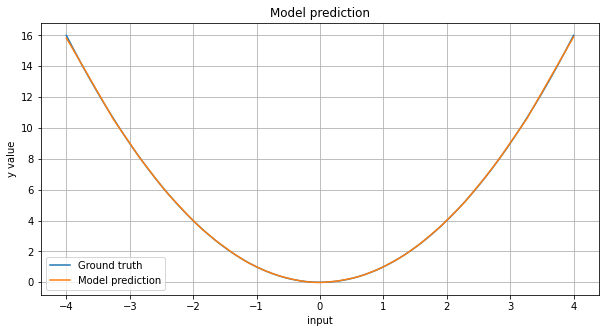

In [8]:
xs_linspace = torch.linspace(-4, 4, 2000).view(-1, 1)
ys_linspace = generate_y(xs_linspace)

fig, axes = plt.subplots(1, 1, figsize=(10, 5))
axes.grid()
axes.plot(xs_linspace, ys_linspace, label='Ground truth')
ys_pred = m(xs_linspace).detach()
axes.plot(xs_linspace, ys_pred, label='Model prediction')
axes.legend()
axes.set_xlabel("input")
axes.set_ylabel("y value")
axes.set_title("Model prediction")
plt.show()

## MLP 로 근사된 목적함수와 제약조건을 가지는 최적화 문제

원래 우리가 풀려고 했던 최적화 문제의 목적함수는 $f(x)$ 였습니다. 우리에게는 $f(x)$의 closed form은 알려져 있지 않고 오직 $f(x)$의 sample만 관측할 수 있다고 생각해볼까요? 그렇다면 우리가 할 수 있는 일은 sample을 모아서 $f(x)$를 잘 근사하는 $f_\theta(x)$ 를 학습한 후, 최적화 문제의 $f(x)$ 자리에 $f_\theta(x)$를 넣어주고 최적화 문제를 푸는 것입니다. 그런 상황은 다음과 같은 수식으로 표현할 수 있습니다.

$$
\begin{aligned}
 \min_{x} &\, f_\theta(x) \\
 \text{s.t.} &\, x_{min} \leq x \leq x_{max} \\
\end{aligned}
$$

자 이제 그러면 위의 수식으로 표현된 최적화 문제를 `scipy.optimize.minimize`를 활용해 푸는 방법에 대해서 알아보겠습니다.

In [14]:
lb, ub = -3.0, -1.0 # declare lower and upper bound of optmization variable

x_init = np.random.uniform(lb, ub) 
x0 = np.ones(1) * x_init
x0_tensor = torch.ones(1,1) * x_init
y0 = m(x0_tensor).detach()

In [15]:
x0

array([-1.99795166])

In [16]:
b = (lb, ub)
bnds = (b,)

soln_nn = minimize(partial(objective, model=m), 
                   x0, 
                   method='SLSQP', 
                   bounds=bnds, 
                   jac=partial(jac, model=m))

## Visualize optimization result

In [17]:
xs_linspace = torch.linspace(-4, 4, 2000).view(-1, 1)
ys_linspace = generate_y(xs_linspace)

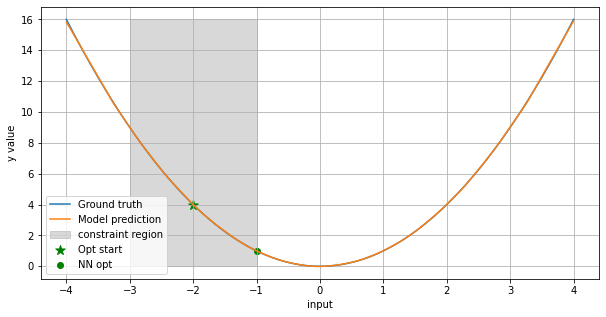

In [18]:
fig, axes = plt.subplots(1, 1, figsize=(10, 5))
axes.grid()
axes.plot(xs_linspace, ys_linspace, label='Ground truth')

ys_pred = m(xs_linspace).detach()
axes.plot(xs_linspace, ys_pred, label='Model prediction')
axes.fill_between(np.linspace(lb, ub, 100),
                  ys_linspace.min(),
                  ys_linspace.max(),
                  color='grey', 
                  alpha=0.3,
                  label='constraint region')
axes.scatter(x_init, y0, label='Opt start', 
             c='green', marker='*', s=100.0)

axes.scatter(soln_nn.x, soln_nn.fun, label='NN opt', c='green')
axes.legend()
axes.set_xlabel("input")
axes.set_ylabel("y value")
plt.show()